# SRIMAX Model

## Content
* Elements
* Data Preprocessing
* Model Identification
* Model Estimation
* Model Verification
* Model Use

Import required tools

In [1]:
import time
import itertools
import joblib
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Get required config

In [2]:
# Set random seed for reproducibility
np.random.seed(42)
# Show all columns ans rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Data Preprocessing

### Load data

In [3]:
# Load data
loading_path = r'/Users/rlg/Desktop/Workspace/data/df_inflation.csv'
df = pd.read_csv(loading_path)
df.head()

,DS,INFLACION,MXN/USD,AG_MONET_M2,TASA_INT,REMESAS,SM_NOM_GENERAL,SM_NOM_ZLFN,PIB_PCONST_VAR_ANUAL_TRIM
0,1/1/2021,3.54,19.9215,10434950530,4.30,3392808480,141.7,213.39,-2.594806
1,2/1/2021,3.76,20.3097,10406909432,4.11,3264101525,141.7,213.39,-2.594806
2,3/1/2021,4.67,20.7555,10516385860,4.02,4275093702,141.7,213.39,-2.594806
3,4/1/2021,6.08,20.0153,10517260240,4.01,4167759579,141.7,213.39,22.702244
4,5/1/2021,5.89,19.9631,10535614830,4.04,4677325083,141.7,213.39,22.702244


In [ ]:
## Basic data manipulations
# Make sure dates are fine
df['DS'] = pd.to_datetime(df['DS'], format='mixed')
# Change column names
df = df.rename(columns = {'DS' : 'ds', 'INFLACION' : 'y'})
# Separate exogenous and endogenous variables
df_endog = df[['ds', 'y']]
df_exog = df.drop(columns = ['y'])


## For endogenous variable
# Get required dates
df_endog_future = df_endog[df_endog['ds'] >= '2025-01-01'] # For forecast evaluation
df_endog = df_endog[df_endog['ds'] < '2025-01-01']
# Set endogenous data
endog = pd.Series(df_endog['y'].values, index = df_endog['ds'], name = 'y')
endog_future = pd.Series(df_endog_future['y'].values, index = df_endog_future['ds'])


## For exogenous variables
# Get required dates
df_exog_future = df_exog[df_exog['ds'] >= '2025-01-01'] # Proyections in order to forecast
df_exog = df_exog[df_exog['ds'] < '2025-01-01']
# Normalize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
exog = pd.DataFrame(
    scaler.fit_transform(df_exog.drop(columns = ['ds'])),
    columns = ['MXN/USD', 'AG_MONET_M2', 'TASA_INT', 'REMESAS', 'SM_NOM_GENERAL', 'SM_NOM_ZLFN', 'PIB_PCONST_VAR_ANUAL_TRIM'],
    index = df_exog['ds']
)
exog_future = pd.DataFrame(
    scaler.fit_transform(df_exog_future.drop(columns = ['ds'])),
    columns = ['MXN/USD', 'AG_MONET_M2', 'TASA_INT', 'REMESAS', 'SM_NOM_GENERAL', 'SM_NOM_ZLFN', 'PIB_PCONST_VAR_ANUAL_TRIM'],
    index = df_exog_future['ds']
)

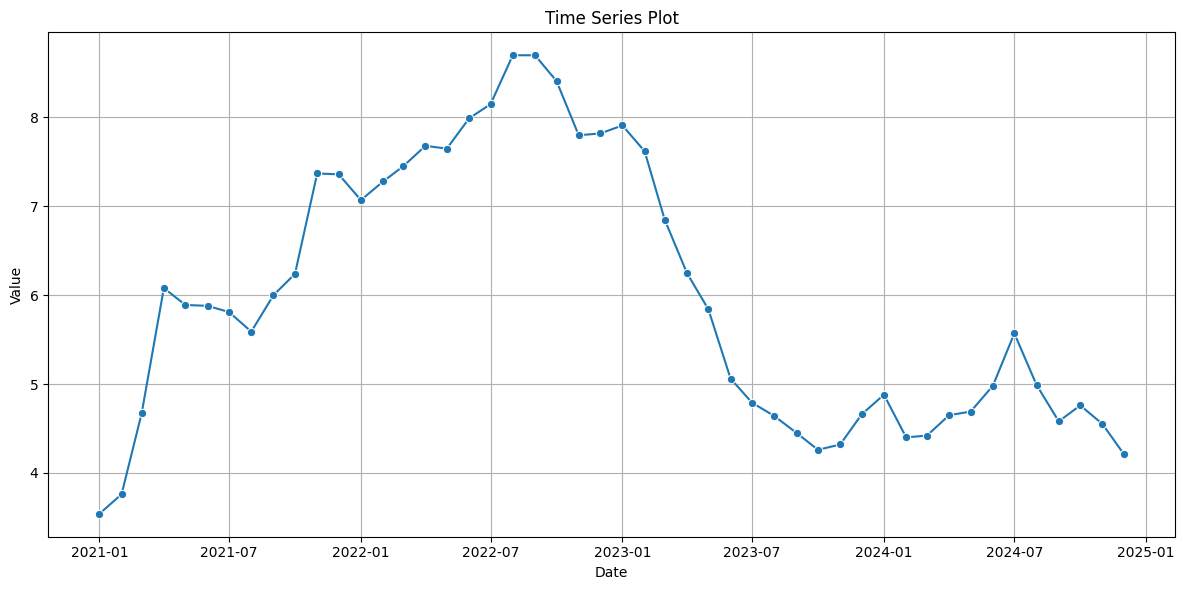

In [5]:
# Plot endogenous variable
plt.figure(figsize=(12, 6))
sns.lineplot(data = endog, marker = 'o')
plt.title("Time Series Plot")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

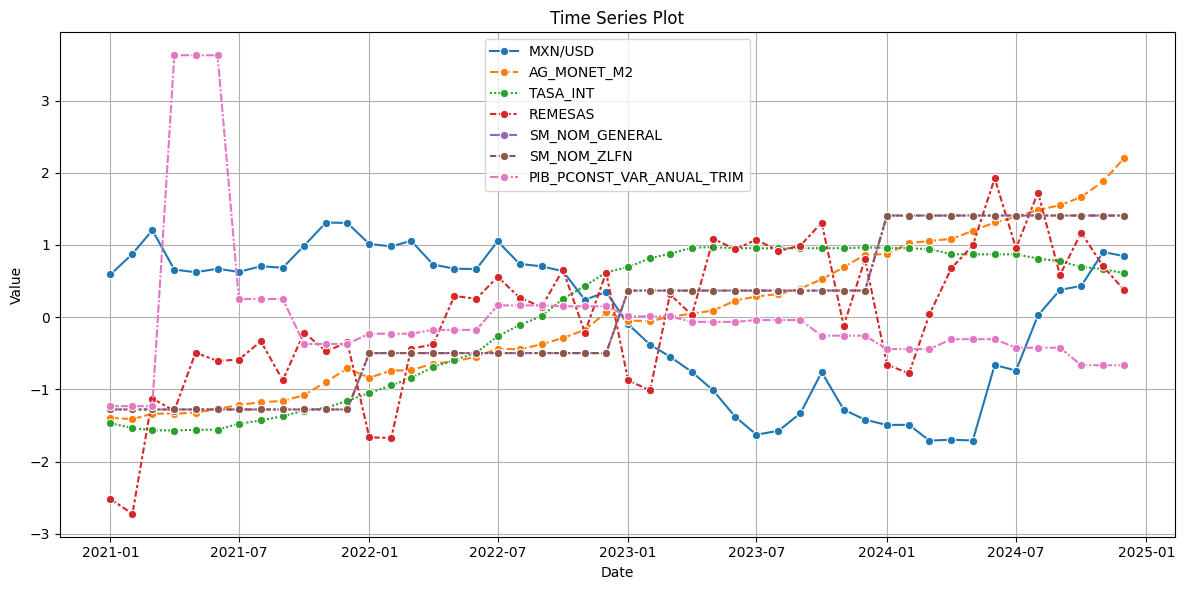

In [6]:
# Plot exogenous variables
plt.figure(figsize=(12, 6))
sns.lineplot(data = exog, marker = 'o')
plt.title("Time Series Plot")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

### Seasonality Determination

**Seasonality determination by visual inspection**  
The goal is to look for patterns or repetitive cycles that recur at regular intervals. Check if there are obvious seasonal fluctuations.

In [ ]:
# Plot data
plt.figure(figsize=(18, 10))
sns.lineplot(data = endog, marker = 'o')
plt.title("Time Series Plot")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.xticks(endog.index, rotation=45, fontsize = 8)
plt.tight_layout()
plt.show()

**Time Series Decomposition**  
The decomposition of time series assumes that the time series is composed of three main components: trend-cycle, which represents the long-term movement of the series; seasonality, which captures effects repeated annually with some consistency; and irregularity, which characterizes unpredictable and considered random movements. We'll focus in the seasonal part. 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

## Decompose the time series
# 52 for weekly time series
# 12 for monthly time series
# 4 for quarterly time series
result = seasonal_decompose(endog, model='additive', period = 12) 

plt.figure(figsize=(14, 8), dpi=100)
plt.plot(result.seasonal)
plt.grid(True)
plt.xticks(endog.index, rotation=45, fontsize = 8)
plt.title('Seasonality')
plt.show()

**ACP**  
Use the ACF to detect seasonal periods by identifying regular patterns or peaks. 
* In the ACF plot, significant peaks at regular intervals indicate the presence of seasonality. For example, if your data is monthly and you see peaks every 12 lags, this suggests a seasonal period of 12 months.
* The pattern of peaks will repeat with the seasonal period. For instance, if the ACF has a peak at lag 12, 24, 36, etc., this implies a seasonal period of 12.

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF
plt.figure(figsize=(28, 16))  
plot_acf(endog, lags = endog.shape[0] - 1) 

# Customize x-axis ticks
plt.xticks(range(0, endog.shape[0], 12), rotation=45, fontsize=8)

plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.grid(True)
plt.show()

### Relevance Analysis for Exogenous Variables (Before Training)

In [ ]:
# Set data
df_present = pd.concat([endog, exog], axis = 1)
endog_var = endog.name
exog_vars = exog.columns
df_present.head()

**Correlation Analysis**  
* Endogenous vs. Exogenous at time $t$.   
Pearson and Spearman correlation of each exogenous variable with endogenous variable in order to get linear or non-linear relationships, respectively, of the endogenous variable and the exogenous variables.  
* Exogenous vs. Exogenous at time $t$.  
Pearson and Spearman correlation of each exogeonus variable with each other in order to avoid multicollinearity.
* Endogenous vs. Exogenous at time $t-1$, $t-3$, and $t-3$.  
Pearson and Spearman correlation of each exogenous variable with endogenous variable in order to get linear or non-linear relationships, respectively, of the endogenous variable and the lagged exogenous variables.

Endogenous vs. Exogenous at time $t$

In [ ]:
# Pearson ans Spearman correlation for each exogenous variable with endogenous variable
corr_pearson = pd.DataFrame(df_present.corr(method='pearson').iloc[0, 1:])
corr_spearman = pd.DataFrame(df_present.corr(method='spearman').iloc[0, 1:])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pearson heatmap
sns.heatmap(corr_pearson, ax=axes[0], annot=True, cmap='coolwarm_r',
            fmt='.2f', square=True, cbar_kws={"shrink": .8})
axes[0].set_title('Pearson Correlations')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

# Spearman heatmap
sns.heatmap(corr_spearman, ax=axes[1], annot=True, cmap='coolwarm_r',
            fmt='.2f', square=True, cbar_kws={"shrink": .8})
axes[1].set_title('Spearman Correlations')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0)

# Adjust layout
plt.tight_layout()

plt.show()


Exogenous vs. Exogenous at time $t$

In [ ]:
# Pearson and Spearman correlations between exogenous variables
corr_exog_pearson  = df_present[exog_vars].corr(method='pearson')
corr_exog_spearman = df_present[exog_vars].corr(method='spearman')

# Create subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pearson heatmap
sns.heatmap(corr_exog_pearson, ax=axes[0], annot=True, cmap='coolwarm_r',
            fmt='.2f', square=True, cbar_kws={"shrink": .8})
axes[0].set_title('Pearson Correlations between Exogenous Variables')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

# Spearman heatmap
sns.heatmap(corr_exog_spearman, ax=axes[1], annot=True, cmap='coolwarm_r',
            fmt='.2f', square=True, cbar_kws={"shrink": .8})
axes[1].set_title('Spearman Correlations between Exogenous Variables')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0)

# Adjust layout
plt.tight_layout()
plt.show()


Endogenous vs. Exogenous at time $t-1$, $t-3$, and $t-3$

In [ ]:
def past_lag_correlations(exog, endog, exog_lags=[1, 2, 3]):
    """
    Compute correlations between lagged exogenous variables and endogenous variable.
    
    IN:
    -> exog: Exogenous variables, indexed by timestamp (pd.DataFrame)
    -> endog: Endogenous variable, indexed by timestamp (pd.Series)
    -> exog_lags: List of integer lags to compute (list)
        
    Returns:
    -> corr_exog_perarson_lagged: Pearson correlation matrix with lags as rows and exog variable names as columns (pd.DataFrame)
    -> corr_exog_spearman_lagged: Spearman correlation matrix with lags as rows and exog variable names as columns (pd.DataFrame)

    Prints:
    -> Heatmaps
    """

    # Ensure endog has a usable name for df indexing
    endog_name = endog.name if endog.name is not None else "endog"

    # Create float-dtype output frames (important for seaborn)
    corr_pearson_lagged = pd.DataFrame(
        index=exog_lags, columns=exog.columns, dtype=float
    )
    corr_spearman_lagged = pd.DataFrame(
        index=exog_lags, columns=exog.columns, dtype=float
    )

    for lag in exog_lags:
        exog_lagged = exog.shift(lag)
        df_aux = pd.concat([endog.rename(endog_name), exog_lagged], axis=1).dropna()

        if df_aux.empty:
            corr_pearson_lagged.loc[lag] = np.nan
            corr_spearman_lagged.loc[lag] = np.nan
            continue

        for col in exog.columns:
            corr_pearson_lagged.at[lag, col] = df_aux[endog_name].corr(df_aux[col], method='pearson')
            corr_spearman_lagged.at[lag, col] = df_aux[endog_name].corr(df_aux[col], method='spearman')

    # Plot heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(16,6))

    sns.heatmap(
        corr_pearson_lagged, ax=axes[0], annot=True, fmt='.2f',
        cmap='coolwarm_r', vmin=-1, vmax=1, cbar_kws={"shrink": .8}
    )
    axes[0].set_title('Pearson Correlations')
    axes[0].set_xlabel('Exogenous Variables')
    axes[0].set_ylabel('Lag')
    axes[0].set_yticklabels(exog_lags, rotation=0)

    sns.heatmap(
        corr_spearman_lagged, ax=axes[1], annot=True, fmt='.2f',
        cmap='coolwarm_r', vmin=-1, vmax=1, cbar_kws={"shrink": .8}
    )
    axes[1].set_title('Spearman Correlations')
    axes[1].set_xlabel('Exogenous Variables')
    axes[1].set_ylabel('Lag')
    axes[1].set_yticklabels(exog_lags, rotation=0)

    plt.tight_layout()
    plt.show()

    return corr_pearson_lagged, corr_spearman_lagged


In [ ]:
# Calculate lagged correlations
corr_pearson_lagged, corr_spearman_lagged = past_lag_correlations(exog = exog, endog = endog, exog_lags=[1, 2, 3])

**Regression Analysis**  
Consider time series $\{Y_t\}$ -endogenous variable- and $\{X_t\}$ -exogenous variable-. The regression analysis refers to run a simple regression $Y_t = X_{t-1} + X_{t-2},...,X_{t-p}$ with $p\in\mathbb{N}$, typically using $p = 1,2,3$, in order to get the statistical significance of the lagged exogenous variables regarding the endogenous variable through $t$-tests. Any $p$-value such that $p < 0.05$ suggests statistical significance, thus a relevant variable. Any other such that $p \geq 0.05$ suggest non-significance, thus an irrelevant variable. 

In [ ]:
# Regression analysis for endogenous variable explained through lagged exogenous variables
def lagged_regression(endog, exog, exog_lags=[1, 2, 3]):
    """
    Fit an OLS regression of endogenous variable on lagged exogenous variables.

    IN:
    -> exog : Exogenous variables, indexed by timestamp (pd.DataFrame)
    -> endog : Endogenous variable, indexed by timestamp (pd.Series)
    -> exog_lags : List of integer lags to compute (list)

    OUT:
    -> results : The fitted OLS model result (statsmodels.regression.linear_model.RegressionResultsWrapper)
    """

    # Set lagged exogenous variables
    X_lagged = pd.concat(
        {
            f"{col}_lag{lag}": exog[col].shift(lag)
            for col in exog.columns
            for lag in exog_lags
        },
        axis=1
    )

    # Align with endog and drop missing
    df_OLS = pd.concat([endog, X_lagged], axis=1).dropna()
    y = df_OLS[endog.name]
    X = df_OLS.drop(columns=[endog.name])

    # Add constant
    X = sm.add_constant(X)

    # Fit OLS
    model = sm.OLS(y, X).fit()
    return model


In [ ]:
lagged_regression_model = lagged_regression(endog, exog, exog_lags=[1, 2, 3])
lagged_regression_model.summary()

## Model Identification
This section is about finding the $(p,d,q)(P,D,Q)_E$ parameters of a SARIMAX model in order to get the best fit with the required data with the following approch:
* Grid search with in-sample metrics ($MAPE$, $R^2$, $MAE$, $AIC$) over $p,d,q, P,D,Q,E$ parameters and Box-Cox transformation.

In [10]:
# Parameter grid
param_grid = {
    'AR_p' : [0,1,2],
    'MA_q' : [0,1,2],
    'd': [0,1,2],
    'SAR_P' : [0,1,2],
    'SMA_Q' : [0,1,2],
    'D' : [0,1,2],
    'E' : [12],
    'Box-Cox' : [True, False]
}

In [11]:
# Import required tools
from itertools import product
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error


# Hyperparameter grid search function
def SARIMAX_GRID_SEARCH_IN_SAMPLE(endog, exog, param_grid, freq, verbose = 0):
    """
    SARIMAX Hyperparameter Grid Search with In-Sample Evaluation

    IN:
    -> endog: endogenous variables at present time (pd.Series)
    -> exog: exogenous variables at present time (pd.DataFrame)
    -> param_grid: hyperparameter grid to search over (dict)
    -> bc_transform: whether to apply Box-Cox transformation (bool)
    -> freq: frequency of the time series data (str)
    -> Weather or not to print progress

    OUT:
    -> df_metrics: Table with hyperparameters combinations and its corresponing in-sample metrics (pandas.DataFrame)
    """ 
    # Print total iterations
    if verbose:
        print('Maximum Iterations: ', len(list(product(*param_grid.values()))))

    # Initialize metrics df and metrics lists
    df_metrics = pd.DataFrame(columns = ['AR_p', 'd', 'MA_q', 'SAR_P', 'D', 'SMA_Q', 'E', 'Box-Cox', 'IN_SAMPLE_MAPE', 'IN_SAMPLE_R2', 'IN_SAMPLE_MAE', 'AIC', 'IN_SAMPLE_TIME'])

    # Initialize iteration counter 
    iter = 1

    # Perform grid search
    for params in product(*param_grid.values()):
        if verbose:
            print('------------------------------')
            print('Iteration: ', iter)
            print('Parameters: ', params)

        # Discard not suitable parameter combinations
        if params[0] == 0 and params[1] == 0:
            if verbose:
                print('Not suitable parameter combination')
        else:



            ### Prepare data
            # Initialize hyperparameters
            p, q, d, P, Q, D, E, bc = params

            # Initialize training data
            endog_train = endog.copy()
            exog_train = exog.copy()

            # Handle Box-Cox transformation
            if bc:
                endog_train, l = boxcox(endog_train)
                endog_train = pd.Series(endog_train, index = endog.index)



            ### Train model
            # Start time
            start_time = time.time()

            # Set model
            model = SARIMAX(
                endog = endog_train, 
                exog = exog_train,
                order = (p, d, q),
                seasonal_order = (P, D, Q, E),
                trend = 'c',
                freq = freq
                )

            # Train model
            results = model.fit()



            ### Get predicted values and actual values
            # Get predicted values
            predicted = results.predict()

            # Handle inverse Box-Cox transformation
            if bc:
                predicted = inv_boxcox(predicted, l)

            # Get actual values
            actual = endog_train
                
            # Stop time 
            end_time = time.time()



            ### Calculate metrics
            mape = mean_absolute_percentage_error(actual, predicted)
            r2 = r2_score(actual, predicted)
            mae = mean_absolute_error(actual, predicted)
            aic = results.aic

            # Fill metrics data frame
            df_metrics_aux = pd.DataFrame({
                'AR_p': [p],
                'd': [d],
                'MA_q': [q],
                'SAR_P': [P],
                'D': [D],
                'SMA_Q': [Q],
                'E': [E],
                'Box-Cox': [bc],
                'IN_SAMPLE_MAPE': [mape],
                'IN_SAMPLE_R2': [r2],
                'IN_SAMPLE_MAE': [mae],
                'AIC' : [aic],
                'IN_SAMPLE_TIME': [end_time - start_time]
                })
            if verbose:
                print(df_metrics_aux.head())
            df_metrics = pd.concat([df_metrics, df_metrics_aux])

        # Increase iteration counter
        iter = iter + 1 

    # Return hyperparameter-metrics data frame
    return df_metrics

In [12]:
# Execute hyperparameter grid search
df_metrics = SARIMAX_GRID_SEARCH_IN_SAMPLE(endog = endog, exog = exog, param_grid = param_grid, freq = 'MS', verbose = 0)
df_metrics = df_metrics.sort_values(by = 'IN_SAMPLE_MAPE')
df_metrics.head()

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/vr/chtthqdd1g74vy5q5gr9ywp40000gn/T/ipykernel_13792/2233646799.py:124: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, df_metrics_aux])
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3

,AR_p,d,MA_q,SAR_P,D,SMA_Q,E,Box-Cox,IN_SAMPLE_MAPE,IN_SAMPLE_R2,IN_SAMPLE_MAE,AIC,IN_SAMPLE_TIME
0,2,0,1,0,0,1,12,False,0.051916,0.910383,0.275930,56.042139,0.126389
0,2,0,1,1,0,2,12,False,0.051975,0.911427,0.275576,59.897519,0.376343
0,2,0,1,0,0,2,12,False,0.052643,0.907900,0.279786,57.960374,0.281211
0,2,0,1,1,0,1,12,False,0.052707,0.905154,0.280170,58.456266,0.170585
0,2,0,1,2,0,1,12,False,0.052866,0.897219,0.275799,58.270898,0.374423


In [ ]:
# Save grid search metrics
#df_metrics.to_csv(r'Observations_TS/sarimax_grid_search_metrics.csv', index = False)

## Model Estimation
This section trains the model with the best $(p,d,q)(P,D,Q)_E$ parameters found in the previous section. 

In [ ]:
# Import required tools
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error


# Train function
def SARIMAX_TRAIN(endog, exog, best_pdqPDQE, bc, freq):
    """
    SARIMAX training function

    IN:
    -> endog: endogenous variable at present time (pd.Series)
    -> exog: exogenous variiables at present time (pd.DataFrame)
    -> best_pdqPDQE: p,d,q, P, D, Q, E model parameters in that order (list)
    -> bc_transform: whether to apply Box-Cox transformation (bool)
    -> freq: frequency of the time series data (str)

    PRINTS:
    MAPE, R2, MAE on train set

    OUT:
    -> model : trained model (joblib)
    """ 
    ### Prepare data
    # Initialize training data
    endog_train = endog.copy()
    exog_train = exog.copy()

    # Initialize parameters
    p = best_pdqPDQE[0]
    d = best_pdqPDQE[1]
    q = best_pdqPDQE[2]
    P = best_pdqPDQE[3]
    D = best_pdqPDQE[4]
    Q = best_pdqPDQE[5]
    E = best_pdqPDQE[6]

    # Handle Box-Cox transformation
    if bc:
        endog_train, l = boxcox(endog_train)
        endog_train = pd.Series(endog_train, index = endog.index)
                
    # Set model
    model = SARIMAX(
         endog = endog_train, 
         exog = exog_train,
         order = (p, d, q),
         seasonal_order = (P, D, Q, E),
         trend = 'c',
         freq = freq
         )

    # Train model
    results = model.fit()



    ### Get predicted values and actual values
    # Get predicted values
    predicted = results.predict()

    # Handle inverse Box-Cox transformation
    if bc:
        predicted = inv_boxcox(predicted, l)
        
    # Get actual values
    actual = endog_train



    ### Calculate metrics
    print('MAPE: ', mean_absolute_percentage_error(actual, predicted))
    print('R2: ', r2_score(actual, predicted))
    print('MAE: ', mean_absolute_error(actual, predicted))
    print('AIC: ', results.aic)
    print(results.summary())

    return results

In [ ]:
# Execute model training
best_pdqPDQE = (1,0,0,2,0,2,12) 
bc = False
freq = 'MS'
model_trained = SARIMAX_TRAIN(endog = endog, exog = exog, best_pdqPDQE = best_pdqPDQE, bc = bc, freq = freq)

In [ ]:
# Save model
#joblib.dump(model_trained, r'Models_TS/sarimax.joblib')

## Model Evaluation
This section evaluates the model using the following approches:
* In-Sample Metrics
* Train-Test Split Metrics
* Assumption Validations

### In-Sample Metrics

In [ ]:
# Import required tools
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error


# Train function
def SARIMAX_EVAL_IN_SAMPLE(endog, exog, best_pdqPDQE, bc, freq):
    """
    SARIMAX training function

    IN:
    -> endog: endogenous variables at present time (pd.Series)
    -> exog: exogenous variables at present time (pd.Series)
    -> best_pdqPDQE: p,d,q,P,D,Q,E model parameters in that order (list)
    -> bc_transform: whether to apply Box-Cox transformation (bool)
    -> freq: frequency of the time series data (str)

    PRINTS:
    MAPE, R2, MAE on train set

    OUT:
    -> df_eval_prediction : table with the actual data and the predicted data (pd.DataFrame)
    """ 

    ### Prepare data
    # Initialize training data
    endog_train = endog.copy()
    exog_train = exog.copy()

    # Initialize parameters
    p = best_pdqPDQE[0]
    d = best_pdqPDQE[1]
    q = best_pdqPDQE[2]
    P = best_pdqPDQE[3]
    D = best_pdqPDQE[4]
    Q = best_pdqPDQE[5]
    E = best_pdqPDQE[6]


     # Handle Box-Cox transformation
    if bc:
        endog_train, l = boxcox(endog_train)
        endog_train = pd.Series(endog_train, index = endog.index)

    # Set model
    model = SARIMAX(
         endog = endog_train, 
         exog = exog_train,
         order = (p, d, q),
         seasonal_order = (P, D, Q, E),
         trend = 'c',
         freq = freq
         )

    # Train model
    results = model.fit()



    ### Get predicted values and actual values
    # Get predicted values
    predicted_full = results.get_prediction()
    predicted = predicted_full.predicted_mean
    conf_int = predicted_full.conf_int()

    # Handle inverse Box-Cox transformation
    if bc:
        predicted = inv_boxcox(predicted, l)
        predicted = pd.Series(predicted, index = endog.index)
        conf_int['lower y'] = inv_boxcox(conf_int['lower y'], l)
        conf_int['upper y'] = inv_boxcox(conf_int['upper y'], l)
        
    # Get actual values
    actual = endog_train

    # Set table with results
    dict_eval_prediction = {
        'y' : actual,
        'y_hat' : predicted, 
        'lower_y' : conf_int['lower y'],
        'upper_y' : conf_int['upper y'] 
    }

    df_eval_prediction = pd.DataFrame(dict_eval_prediction, index = endog.index)


    ### Calculate metrics
    print('MAPE: ', mean_absolute_percentage_error(actual, predicted))
    print('R2: ', r2_score(actual, predicted))
    print('MAE: ', mean_absolute_error(actual, predicted))

    return df_eval_prediction


In [ ]:
# Get in-sample evaluation
best_pdqPDQE = (1,0,0,2,0,2,12) 
bc = False
freq = 'MS'
df_eval_prediction = SARIMAX_EVAL_IN_SAMPLE(endog = endog, exog = exog, best_pdqPDQE = best_pdqPDQE , bc = bc, freq = freq)
df_eval_prediction.head()

In [ ]:
### Plot actual vs. predicted
# Set a nice theme
sns.set_theme(style="whitegrid", palette="muted")

# Ensure datetime index
df_eval_prediction.index = pd.to_datetime(df_eval_prediction.index)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot actual
sns.lineplot(
    x=df_eval_prediction.index,
    y=df_eval_prediction['y'],
    label='Actual',
    marker='o',
    linewidth=2
)

# Plot predicted
sns.lineplot(
    x=df_eval_prediction.index,
    y=df_eval_prediction['y_hat'],
    label='Predicted',
    linestyle='--',
    marker='X',
    linewidth=2
)

# Plot confidence interval manually
plt.fill_between(
    df_eval_prediction.index,
    df_eval_prediction['lower_y'],
    df_eval_prediction['upper_y'],
    color='skyblue',
    alpha=0.3,
    label='95% CI'
)

# Titles and labels
plt.title('Actual vs. Predicted', fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
# Ticks and legend
plt.xticks(rotation=45)
plt.legend(frameon=True)
sns.despine()
plt.tight_layout()
plt.show()


### Train-Test Metrics

In [ ]:
# Import required tools
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error


# Train function
def SARIMAX_EVAL_TAIN_TEST(endog, exog, best_pdqPDQE, bc, test_size, freq):
    """
    ARIMA training function

    IN:
    -> endog: endogenous variables at present time (pd.Series)
    -> exog: exogenous variables at present time (pd.Series)
    -> best_pdqPDQE: p,d,q,P,D,Q,E model parameters in that order (list)
    -> bc_transform: whether to apply Box-Cox transformation (bool)
    -> test_size : last months to evaluate model (str)
    -> freq: frequency of the time series data (str)

    PRINTS:
    MAPE, R2, MAE on test set

    OUT:
    -> df_eval_forecast : table with the actual data and the predicted and forecasted data (pd.DataFrame)
    """ 
    ### Prepare data
    # Initialize training data
    full_index = endog.index
    endog_train = endog.head(endog.shape[0] - test_size)
    exog_train = exog.head(exog.shape[0] - test_size)
    train_index = endog_train.index
    endog_test = endog.tail(test_size)
    exog_test = exog.tail(test_size)
    test_index = endog_test.index

    # Initialize parameters
    p = best_pdqPDQE[0]
    d = best_pdqPDQE[1]
    q = best_pdqPDQE[2]
    P = best_pdqPDQE[3]
    D = best_pdqPDQE[4]
    Q = best_pdqPDQE[5]
    E = best_pdqPDQE[6]

     # Handle Box-Cox transformation
    if bc:
        endog_train, l = boxcox(endog_train)
        endog_train = pd.Series(endog_train, index = train_index)



    ### Train model
    # Set model
    model = SARIMAX(
         endog = endog_train, 
         exog = exog_train,
         order = (p, d, q),
         seasonal_order = (P, D, Q, E),
         trend = 'c',
         freq = freq
         )

    # Train model
    results = model.fit()



    ### Get forecasted values and actual values
    # Get predicted values
    predicted_full = results.get_prediction()
    predicted = predicted_full.predicted_mean
    ci_predicted = predicted_full.conf_int()
    
    # Get forecasted values
    forecasted_full = results.get_forecast(steps = test_size, exog = exog_test)
    forecasted = forecasted_full.predicted_mean
    ci_forecasted = forecasted_full.conf_int()

    # Handle inverse Box-Cox transformation
    if bc:
        predicted = inv_boxcox(predicted, l)
        predicted = pd.Series(predicted, index = train_index)
        ci_predicted['lower y'] = inv_boxcox(ci_predicted['lower y'], l)
        ci_predicted['upper y'] = inv_boxcox(ci_predicted['upper y'], l)
        forecasted = inv_boxcox(forecasted, l)
        forecasted = pd.Series(forecasted, index = test_index)
        ci_forecasted['lower y'] = inv_boxcox(ci_forecasted['lower y'], l)
        ci_forecasted['upper y'] = inv_boxcox(ci_forecasted['upper y'], l)

    # Get actual values
    actual = endog_test

    # Set table with results
    full = endog
    full_hat = pd.concat([predicted, forecasted], axis = 0)
    ci_full = pd.concat([ci_predicted, ci_forecasted], axis = 0)
    dict_eval_forecast = {
        'y' : full,
        'y_hat' : full_hat, 
        'lower_y' : ci_full['lower y'],
        'upper_y' : ci_full['upper y'] 
    }
    df_eval_forecast = pd.DataFrame(dict_eval_forecast, index = full_index)
    
    ### Calculate metrics
    print('MAPE: ', mean_absolute_percentage_error(actual, forecasted))
    print('R2: ', r2_score(actual, forecasted))
    print('MAE: ', mean_absolute_error(actual, forecasted))

    return df_eval_forecast

In [ ]:
best_pdqPDQE = (1,0,0,2,0,2,12)
test_size = 6
bc = False
freq = 'MS'
df_eval_forecast = SARIMAX_EVAL_TAIN_TEST(endog = endog, exog = exog, best_pdqPDQE = best_pdqPDQE, bc = bc, test_size = test_size, freq = freq)
df_eval_forecast.head()

In [ ]:
### Plot actual vs. predicted and forecasted
# Set a nice theme
sns.set_theme(style="whitegrid", palette="muted")

# Ensure datetime index
df_eval_forecast.index = pd.to_datetime(df_eval_forecast.index)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot actual
sns.lineplot(
    x=df_eval_forecast.index,
    y=df_eval_forecast['y'],
    label='Actual',
    marker='o',
    linewidth=2
)

# Plot predicted
sns.lineplot(
    x=df_eval_forecast.index,
    y=df_eval_forecast['y_hat'],
    label='Predicted',
    linestyle='--',
    marker='X',
    linewidth=2
)

# Plot confidence interval manually
plt.fill_between(
    df_eval_forecast.index,
    df_eval_forecast['lower_y'],
    df_eval_forecast['upper_y'],
    color='skyblue',
    alpha=0.3,
    label='95% CI'
)

# 👉 Highlight forecast region
forecast_start = df_eval_forecast.index[-6]
forecast_end = df_eval_forecast.index[-1]
plt.axvspan(
    forecast_start, forecast_end,
    color='lightgrey',
    alpha=0.5,
    label='Forecast Period'
)

# Titles and labels
plt.title('Actual vs. Predicted', fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Ticks and legend
plt.xticks(rotation=45)
plt.legend(frameon=True)
sns.despine()
plt.tight_layout()
plt.show()


### Assumptions Verification

## Model Use
This section predict future values with it's required confidence intervals.

In [ ]:
# Impomrt required tools
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error

def SARIMAX_FORECAST(endog, exog, exog_future, n_periods, best_pdqPDQE, bc, freq):
    """
    SARIMAX forecasting function

    IN:
    -> endog: endogenous variables at present time (pd.Series)
    -> exog: exogenous variables at present time (pd.DataFrame)
    -> exog_future: exogenous variables for forecast horizon (pd.DataFrame)
    -> n_periods : periods to forecast (int)
    -> best_pdqPDQE: p,d,q,P,D,Q model parameters in that order (list)
    -> bc_transform: whether to apply Box-Cox transformation or not (bool)
    -> freq: frequency of the time series data (str)

    OUT:
    -> df_eval_forecast : table with the actual data and the predicted and forecasted data. Note there won't be actual data for forecasting periods (pd.DataFrame)
    """ 
    ### Prepare data
    # Initialize training data
    endog_train = endog.copy()
    exog_train = exog.copy()
    train_index = endog_train.index
    forecast_index = pd.date_range(
        start = endog.index[-1] + pd.tseries.frequencies.to_offset(freq),
        periods = n_periods,
        freq = freq)
    full_index = train_index.append(forecast_index)

    # Initialize parameters
    p = best_pdqPDQE[0]
    d = best_pdqPDQE[1]
    q = best_pdqPDQE[2]
    P = best_pdqPDQE[3]
    D = best_pdqPDQE[4]
    Q = best_pdqPDQE[5]
    E = best_pdqPDQE[6]

     # Handle Box-Cox transformation
    if bc:
        endog_train, l = boxcox(endog_train)
        endog_train = pd.Series(endog_train, index = train_index)


    ### Train model
    # Set model
    model = SARIMAX(
         endog = endog_train, 
         exog = exog_train,
         order = (p, d, q),
         seasonal_order = (P, D, Q, E),
         trend = 'c'
         )

    # Train model
    results = model.fit()



    ### Predict and forecast
    # Get predicted values
    predicted_full = results.get_prediction()
    predicted = predicted_full.predicted_mean
    ci_predicted = predicted_full.conf_int()
    
    # Get forecasted values
    forecasted_full = results.get_forecast(steps = n_periods, exog = exog_future)
    forecasted = forecasted_full.predicted_mean
    ci_forecasted = forecasted_full.conf_int()

    # Handle inverse Box-Cox transformation
    if bc:
        predicted = inv_boxcox(predicted, l)
        predicted = pd.Series(predicted, index = train_index)
        ci_predicted['lower y'] = inv_boxcox(ci_predicted['lower y'], l)
        ci_predicted['upper y'] = inv_boxcox(ci_predicted['upper y'], l)
        forecasted = inv_boxcox(forecasted, l)
        forecasted = pd.Series(forecasted, index = forecast_index)
        ci_forecasted['lower y'] = inv_boxcox(ci_forecasted['lower y'], l)
        ci_forecasted['upper y'] = inv_boxcox(ci_forecasted['upper y'], l)

    # Set table with results
    full = pd.concat([endog, pd.Series([np.nan]*n_periods, index = forecast_index)], axis = 0)
    full_hat = pd.concat([predicted, forecasted], axis = 0)
    ci_full = pd.concat([ci_predicted, ci_forecasted], axis = 0)
    dict_forecast = {
        'y' : full,
        'y_hat' : full_hat, 
        'lower_y' : ci_full['lower y'],
        'upper_y' : ci_full['upper y'], 
    }
    df_forecast = pd.DataFrame(dict_forecast, index = full_index)

    return df_forecast

In [ ]:
# Forecast
n_periods = 6
best_pdqPDQE = (1,0,0,2,0,2,12)
bc = False
freq = 'MS'
df_forecast = SARIMAX_FORECAST(endog = endog, exog = exog, exog_future = exog_future, n_periods = n_periods, best_pdqPDQE = best_pdqPDQE, bc = bc, freq = freq)
df_forecast.tail(n_periods*2)

In [ ]:
### Plot actual vs. predicted and forecasted
# Set a nice theme
sns.set_theme(style="whitegrid", palette="muted")

# Ensure datetime index
df_forecast.index = pd.to_datetime(df_forecast.index)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot actual
sns.lineplot(
    x=df_forecast.index,
    y=df_forecast['y'],
    label='Actual',
    marker='o',
    linewidth=2
)

# Plot predicted
sns.lineplot(
    x=df_forecast.index,
    y=df_forecast['y_hat'],
    label='Predicted',
    linestyle='--',
    marker='X',
    linewidth=2
)

# Plot confidence interval manually
plt.fill_between(
    df_forecast.index,
    df_forecast['lower_y'],
    df_forecast['upper_y'],
    color='skyblue',
    alpha=0.3,
    label='95% CI'
)

# Highlight forecast region
forecast_start = df_forecast.index[-n_periods]
forecast_end = df_forecast.index[-1]
plt.axvspan(
    forecast_start, forecast_end,
    color='lightgrey',
    alpha=0.5,
    label='Forecast Period'
)

# Titles and labels
plt.title('Actual vs. Predicted', fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Ticks and legend
plt.xticks(rotation=45)
plt.legend(frameon=True)
sns.despine()
plt.tight_layout()
plt.show()


In [ ]:
# Evaluate since we know the future data
print('MAPE: ', mean_absolute_percentage_error(endog_future, df_forecast['y_hat'].tail(6)))
print('R2: ', r2_score(endog_future, df_forecast['y_hat'].tail(6)))
print('MAE: ', mean_absolute_error(endog_future, df_forecast['y_hat'].tail(6)))

In [ ]:
exog_future.head()

In [ ]:
exog.head()